In [1]:
import gym
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import softmax
%matplotlib inline

In [2]:
HIT = 1
STAND = 0
DOUBLE = 2
GAMMA = 1

In [3]:
env = gym.make('Blackjack-v1', natural = True, sab = False)

# Часть 1
## 1. Статическая стратегия

In [4]:
def play_game_static(env = env, max_points = 19, debug = False):
    env.reset()
    done = False
    while env._get_obs()[0] < max_points:
        res = env.step(HIT)
        done = res[2]
    if not done:
        res = env.step(STAND)
    if debug:
        print(env.player)
        print(env.dealer)
    return res[1], env.player, env.dealer[0]

In [5]:
wins = []
for i in range(21):
    s = 0
    for _ in range(100000):
        reward, _, _ = play_game_static(env, i)
        s += reward
    wins.append(s / 100000)

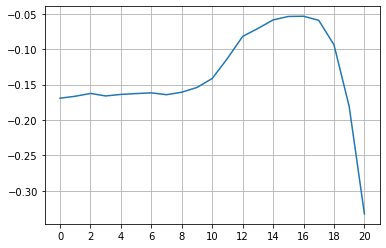

In [6]:
fig = plt.plot(wins)
plt.xticks(np.arange(0, 22, 2))
plt.grid(axis = 'both')
plt.show()

In [7]:
np.argmax(wins)

16

In [8]:
wins[np.argmax(wins)]

-0.053505

## Оптимальный выигрыш (вернее, проигрыш) достигается при стратегии брать карту при сумме очков меньше 15 или 16 и останавливаться в противном случае. Так мы будет проигрывать около 5% ставки

In [9]:
states = {}

In [10]:
N_PLAY_REPEAT = 10 ** 4
def play_with_states(states = states, env = env):
    result = 0
    for i in range(N_PLAY_REPEAT):
        done = False
        env.reset()
        while not done:
            p_hand = str(sorted(env.player)).strip('[]')
            d_hand = env.dealer[0]
            if p_hand not in states.keys() or d_hand not in states[p_hand].keys():
                action = np.random.choice([STAND, HIT], size = 1)[0]
            else:
#                 print('jjj')
                r_dict = states[p_hand][d_hand]
                if r_dict[STAND] > r_dict[HIT]:
                    action = STAND
                else:
                    action = HIT
            res = env.step(action)
            done = res[2]
        result += res[1]
    return result / N_PLAY_REPEAT

In [11]:
play_with_states(states={}, env = env)

-0.375

In [12]:
play_with_states(states=states, env = env)

-0.3662

In [13]:
states = {}
mean_rewards = []
hit_action = str(HIT)
stand_action = str(STAND)
for i in range(1000000):
    if i % 10000 == 0:
        mean_rewards.append(play_with_states(states=states, env=env))
        print(i, mean_rewards[-1])
    env.reset()
    done = False
    while not done:
        p_hand = str(sorted(env.player)).strip('[]')
        d_hand = env.dealer[0]
        if p_hand not in states.keys():
            states[p_hand] = {d_hand: {STAND: 0, HIT: 0}}
        elif d_hand not in states[p_hand].keys():
            states[p_hand][d_hand] = {STAND: 0, HIT: 0}
        act_probs = np.array([x for x in states[p_hand][d_hand].values()])[:2]
        act_probs = softmax(act_probs)
        action = np.random.choice([STAND, HIT], size=1, p = act_probs)[0]
        if p_hand == '1, 10':
            action = STAND
        res = env.step(action)
        done = res[2]
    reward = res[1]
    states[p_hand][d_hand][action] += reward
    for i in range(len(env.player) - 1, 1, -1):
        p_hand = str(sorted(env.player[:i])).strip('[]')
        reward *= GAMMA
        states[p_hand][d_hand][HIT] += reward


0 -0.36995
10000 -0.1487
20000 -0.1127
30000 -0.1171
40000 -0.11245
50000 -0.10845
60000 -0.1053
70000 -0.08955
80000 -0.09035
90000 -0.08205
100000 -0.0714
110000 -0.09025
120000 -0.07885
130000 -0.0774
140000 -0.0594
150000 -0.07975
160000 -0.0763
170000 -0.07465
180000 -0.0786
190000 -0.05445
200000 -0.0898
210000 -0.065
220000 -0.0526
230000 -0.08385
240000 -0.06405
250000 -0.05435
260000 -0.05685
270000 -0.10195
280000 -0.05705
290000 -0.0698
300000 -0.0796
310000 -0.09035
320000 -0.06865
330000 -0.07345
340000 -0.0753
350000 -0.07215
360000 -0.05155
370000 -0.075
380000 -0.06995
390000 -0.0838
400000 -0.06725
410000 -0.0711
420000 -0.0731
430000 -0.06275
440000 -0.07285
450000 -0.08015
460000 -0.05645
470000 -0.0802
480000 -0.0709
490000 -0.09125
500000 -0.0595
510000 -0.0512
520000 -0.0779
530000 -0.0719
540000 -0.06985
550000 -0.07015
560000 -0.0726
570000 -0.06435
580000 -0.0915
590000 -0.06145
600000 -0.07695
610000 -0.05875
620000 -0.07335
630000 -0.07725
640000 -0.06135
650

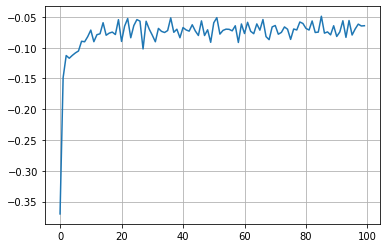

In [14]:
fig = plt.plot(mean_rewards)
plt.grid(axis = 'both')
plt.show()

## Пришли примерно туда же

# Удвоения и счет

In [16]:
import gym
from gym import spaces
from gym.utils import seeding

def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
deck_counts = np.array([4, 4, 4, 4, 4, 4, 4, 4, 4, 16])

def draw_card(np_random):
    card = int(np_random.choice(deck, p = deck_counts / sum(deck_counts)))
    deck_counts[card - 1] -= 1
    return card

def reset_deck():
    global deck_counts 
    deck_counts = np.array([4, 4, 4, 4, 4, 4, 4, 4, 4, 16])

def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class myBlackjackEnv(gym.Env):

    def __init__(self, natural=False, sab=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        deck_reset = False
        double_mul = 1
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                if sum(deck_counts) < 15:
                    reset_deck()
                    deck_reset = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
        else:  # stick: play out the dealers hand, and score
            done = True
            if action == 2:
                double_mul = 2
                self.player.append(draw_card(self.np_random))
                if is_bust(self.player):
                    if sum(deck_counts) < 15:
                        reset_deck()
                        deck_reset = True
                    return self._get_obs(), -2, done, {}, deck_reset
#                     return -2
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
            if sum(deck_counts) < 15:
                reset_deck()
                deck_reset = True
        return self._get_obs(), reward * double_mul, done, {}, deck_reset

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

In [76]:
BID_VALS = [1, 2, 4, 8, 16, 32, 64, 128] #Bid multipliers
PS_SCORE = np.array([x for x in range(-44, 45, 1)]) / 2

In [77]:
bid_dict = {}
for s in PS_SCORE:
    bid_dict[s] = {}
    for b in BID_VALS:
        bid_dict[s][b] = 0

In [78]:
update_dict = {
    1: -1,
    2: 0.5,
    3: 1,
    4: 1,
    5: 1.5,
    6: 1, 
    7: 0.5,
    8: 0,
    9: -0.5,
    10: -1
}

In [79]:
EPS = 0.05

In [80]:
def select_bid(counter, bid_dict = bid_dict):
#     if counter > 10:
#         counter = 10
#     if counter < -10:
#         counter = -10
#     bid_probs = np.array([x for x in bid_dict[counter].values()])
#     bid_probs = softmax(bid_probs)
#     bid = np.random.choice([x for x in bid_dict[counter].keys()], size=1, p = bid_probs)[0]
    if np.random.random() < EPS:
        bid = np.random.choice([x for x in bid_dict[counter].keys()], size=1)[0]
    else:
        bid_vals = np.array([x for x in bid_dict[counter].values()])
        bid = [x for x in bid_dict[counter].keys()][np.argmax(bid_vals)]
    return bid

In [81]:
mean_rewards = []
states = {}
hit_action = str(HIT)
stand_action = str(STAND)
double_action = str(DOUBLE)

bid_dict = {}
for s in PS_SCORE:
    bid_dict[s] = {}
    for b in BID_VALS:
        bid_dict[s][b] = 0

env = myBlackjackEnv(natural=True, sab=True)
counter = 0
total_wins = 0
for i in range(10000000):
    if i > 2000000:
        cur_bid = select_bid(counter)
    else:
        cur_bid = 1
    env.reset()
    done = False
    cur_counter = counter
    #update counter with visible cards
    cur_counter += update_dict[env.player[0]] + update_dict[env.player[1]] + update_dict[env.dealer[0]]
    trace = []
    while not done:
        p_hand = str(sorted(env.player)).strip('[]')
        d_hand = env.dealer[0]
        if cur_counter not in states.keys():
            states[cur_counter] = {p_hand: {d_hand: {STAND: 0, HIT: 0, DOUBLE:0}}}
        elif p_hand not in states[cur_counter].keys():
            states[cur_counter][p_hand] = {d_hand: {STAND: 0, HIT: 0, DOUBLE:0}}
        elif d_hand not in states[cur_counter][p_hand].keys():
            states[cur_counter][p_hand][d_hand] = {STAND: 0, HIT: 0, DOUBLE:0}
#         act_probs = np.array([x for x in states[cur_counter][p_hand][d_hand].values()])
#         act_probs = softmax(act_probs)
#         action = np.random.choice([STAND, HIT, DOUBLE], size=1, p = act_probs)[0]
        if np.random.random() < EPS:
            action = np.random.choice([STAND, HIT, DOUBLE], size=1)[0]
        else:
            act_vals = [x for x in states[cur_counter][p_hand][d_hand].values()]
            action = [x for x in states[cur_counter][p_hand][d_hand].keys()][np.argmax(act_vals)]
        trace.append([cur_counter, p_hand, d_hand])
        if p_hand == '1, 10':
            action = STAND
        res = env.step(action)
        done = res[2]
        if action != STAND:
            cur_counter += update_dict[env.player[-1]]
        if done:
            for c in env.dealer[1:]:
                cur_counter += update_dict[c]
    reward = res[1]
    for t in trace[:-1]:
        states[t[0]][t[1]][t[2]][HIT] += reward
    t = trace[-1]
    states[t[0]][t[1]][t[2]][action] += reward
    if i > 2000000:
        bid_dict[counter][cur_bid] += reward * cur_bid
    if res[4]:
        counter = 0
    else:
        counter = cur_counter
    total_wins += reward * cur_bid
    if i % 100000 == 0:
        print(i, total_wins / 100000)
        total_wins = 0

0 -1e-05
100000 -0.20879
200000 -0.19417
300000 -0.19007
400000 -0.19361
500000 -0.19157
600000 -0.18279
700000 -0.17873
800000 -0.18146
900000 -0.18059
1000000 -0.17626
1100000 -0.18453
1200000 -0.17555
1300000 -0.18182
1400000 -0.1727
1500000 -0.17081
1600000 -0.17145
1700000 -0.18465
1800000 -0.17967
1900000 -0.17052
2000000 -0.17384
2100000 -0.42546
2200000 -0.43495
2300000 -0.452
2400000 -0.43172
2500000 -0.40445
2600000 -0.5455
2700000 -0.48635
2800000 -0.5134
2900000 -0.42034
3000000 -0.49523
3100000 -0.42543
3200000 -0.3981
3300000 -0.40455
3400000 -0.41083
3500000 -0.38
3600000 -0.45104
3700000 -0.47604
3800000 -0.43823
3900000 -0.33858
4000000 -0.43002
4100000 -0.43715
4200000 -0.4584
4300000 -0.3571
4400000 -0.51591
4500000 -0.55254
4600000 -0.3639
4700000 -0.37352
4800000 -0.52149
4900000 -0.45186
5000000 -0.46101
5100000 -0.43072
5200000 -0.46597
5300000 -0.46204
5400000 -0.44095
5500000 -0.42187
5600000 -0.3508
5700000 -0.39285
5800000 -0.40658
5900000 -0.40566
6000000 -0